# Realisez des indexations automatiques d'images

# SOMMAIRE

* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [DATASET](#CHARGEMENT)
* [CNN](#CNN)
    * [VGG16](#VGG16)
    * [VGG19](#VGG19)
    * [Layers visualization](#Layers-visualization)

# PREPARATION

## Import des librairies

In [2]:
import re
import joblib
import cv2
import glob
import numpy as np

import matplotlib.pyplot as plt
import random

import keras
import tensorflow as tf
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import preprocess_input

from sklearn. model_selection import train_test_split

## Paramètrage du notebook

## Déclaration des fonctions

In [3]:
from keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten
from keras.models import Model

def conv3x3(input_x,nb_filters):
    """
    Wrapper around convolution layer
    Inputs:
        input_x: input layer / tensor
        nb_filter: Number of filters for convolution
    """
    return Conv2D(nb_filters, kernel_size=(3,3), use_bias=False,
               activation='relu', padding="same",input_shape=(128, 128, 3))(input_x)

def std_image(image):
        image=image.astype('float32') # convert from integers to floats
        image-= image.mean()
        image/= image.std ()
        image*=  64
        image+= 128
        image/=255 # normalize to the range 0-1
        return image

def create_model(img_h=128, img_w=128):
    """
    Creates a CNN model for training. 
    Inputs: 
        img_h: input image height
        img_w: input image width
    Returns:
        Model structure 
    """
    
    inputs = Input(shape=(img_h, img_w, 3))

    x = conv3x3(inputs, 32)
    x = conv3x3(x, 32)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = conv3x3(x, 64)
    x = conv3x3(x, 64)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = conv3x3(x, 128)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    preds = Dense(nb_class, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=preds)
    model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
    print(model.summary())
    return model

In [4]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

def create_model_2(img_h=128, img_w=128): # Creation du modele
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32,
        (3,3),
        input_shape=(img_h,img_w,3), 
        activation='relu',
        padding='same'
        ))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    model.add(tf.keras.layers.Conv2D(64,
        (3,3),
        activation='relu',
        padding='same'
        ))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(120,
        activation='softmax'))
    model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
    print(model.summary())
    return model

In [5]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

def create_model_3(img_h=128, img_w=128): # Creation du modele
    model = tf.keras.models.Sequential()
    model.add(keras.Input(shape=(img_h, img_w, 3)))
    model.add(tf.keras.layers.Rescaling(1./255))
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(120, activation="softmax"))
    model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
    print(model.summary())
    return model

In [6]:
def create_model_vgg16(img_h=128, img_w=128):
    vgg = VGG16(input_shape=(img_h, img_w, 3), weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(120, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

In [7]:
def create_model_vgg19(img_h=128, img_w=128):
    vgg = VGG19(input_shape=(img_h, img_w, 3), weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(120, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

# CHARGEMENT

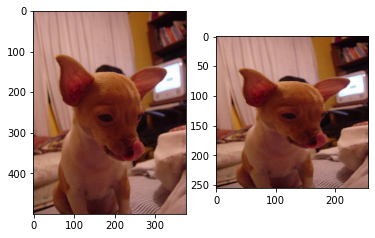

In [8]:
# DEBUG - comparaison entre l'original et l'image retaillée

imgs=[]

for img in glob.glob("/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/n02085620-Chihuahua/*.jpg"):
    #print(img)
    i=cv2.imread(img,cv2.IMREAD_COLOR)
    imgs.append(i)

original=imgs[35][:,:,::-1] #opencv defaults read color into BGR -> convert to RGB
resized=cv2.resize(original, (256, 256),interpolation = cv2.INTER_NEAREST)
plt.subplot(1, 2, 1)
plt.imshow(original)

plt.subplot(1, 2, 2)
plt.imshow(resized)

plt.show()

In [9]:
# liste des fichiers
#filelist=glob.glob('/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/n02085620-Chihuahua/*.jpg')
filelist=glob.glob('/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/*/*.jpg')

In [10]:
#XSubset=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/XSubset.jbl.bz2')
#ySubset=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/ySubset.jbl.bz2')
#dictDogTypes=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/dictDogTypes.jbl.bz2')

# DATASET

In [11]:
# chargement des labels (a partir des noms de repertoires)

dogTypes=[]
for file in filelist:
    #print(f"[{i}]-{file}")
    d=re.match("\S+\/n\d+-(.*)\/\S+.jpg",file)
    dogType=d.group(1)
    dogTypes.append(dogType)
len(dogTypes)

20580

In [12]:
%%time
# numpy array des images (format numpy)
X = np.array([cv2.resize(cv2.imread(file)[:,:,::-1], (256, 256),interpolation = cv2.INTER_NEAREST) for file in filelist])
X.shape, X.nbytes

CPU times: user 1min, sys: 10.2 s, total: 1min 11s
Wall time: 1min 19s


((20580, 256, 256, 3), 4046192640)

In [13]:
%%time
joblib.dump(X,"dogs_numpy.jbl.bz2")

CPU times: user 5min 10s, sys: 4.16 s, total: 5min 14s
Wall time: 5min 15s


['dogs_numpy.jbl.bz2']

In [14]:
# dictionnaire index-> race chien
dictDogTypes=dict(enumerate(np.unique(dogTypes)))
# dictionnaire inversé race chien->classe
dictClasses = dict(map(reversed, dictDogTypes.items()))

dictClasses

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [15]:
joblib.dump(dictDogTypes,'dictDogTypes.jbl.bz2')

['dictDogTypes.jbl.bz2']

In [18]:
y=[dictClasses[dogType] for dogType in dogTypes]

In [16]:
N=10000 # nombres de photos dans l'échantillon
# selection d'index de photo et labels au hasard
randomIndices=random.sample(list(np.arange(len(X))),N)
#randomIndices

In [19]:
XSubset=X[randomIndices]
ySubset=np.array(y)[randomIndices]

In [20]:
%%time
joblib.dump(XSubset,"XSubset.jbl.bz2")

CPU times: user 2min 29s, sys: 1.9 s, total: 2min 31s
Wall time: 2min 31s


['XSubset.jbl.bz2']

In [21]:
%%time
joblib.dump(ySubset,"ySubset.jbl.bz2")

CPU times: user 3.99 ms, sys: 2.38 ms, total: 6.36 ms
Wall time: 5.05 ms


['ySubset.jbl.bz2']

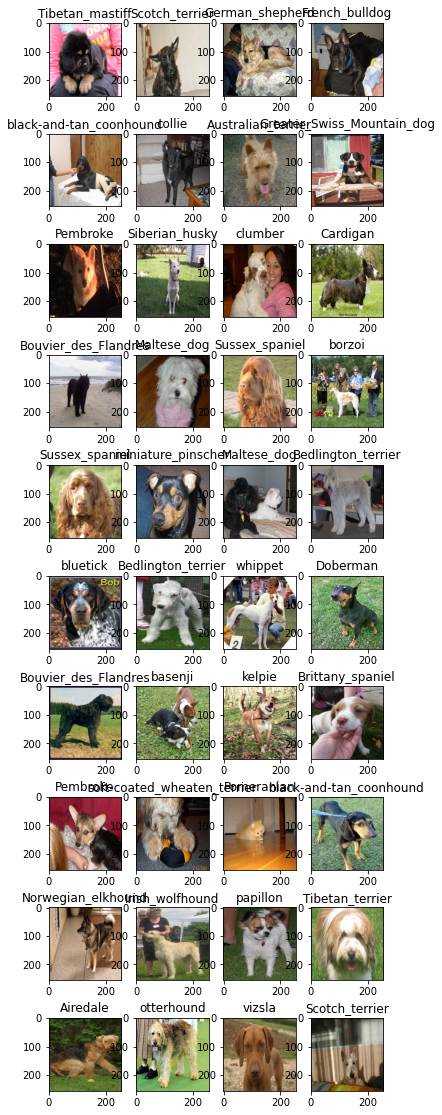

In [22]:
# specify the number of rows and columns you want to see
num_row =10
num_col = 4

# get a segment of the dataset
num = num_row*num_col
images = XSubset[:num]
labels = ySubset[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i])
    ax.set_title(f'{dictDogTypes[labels[i]]}')
#plt.tight_layout()
plt.show()

# CNN

## Random

In [ ]:
# setup parameters
batch_sz = 128  # batch size 
nb_class = 120  # target number of classes
nb_epochs = 12 # training epochs
img_h, img_w = 256, 256  # input dimensions

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XSubset, ySubset, test_size=0.3, random_state=42)

In [ ]:
model = create_model(128,128)

In [ ]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('mnist_cnn.h5')

In [ ]:
X_train.shape,y_train.shape

In [ ]:
%%time
# start training
history=model.fit(X_train, y_train,
          batch_size=batch_sz,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(X_test, y_test), 
          callbacks=[callback])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('reseau neuronal')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [ ]:
# Evaluate and print accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
%%time
#model = tf.keras.models.load_model("cnn3")

In [ ]:
model.save('cnn3')

## VGG16

In [ ]:
model_vgg16 = create_model_vgg16(img_w,img_h)

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

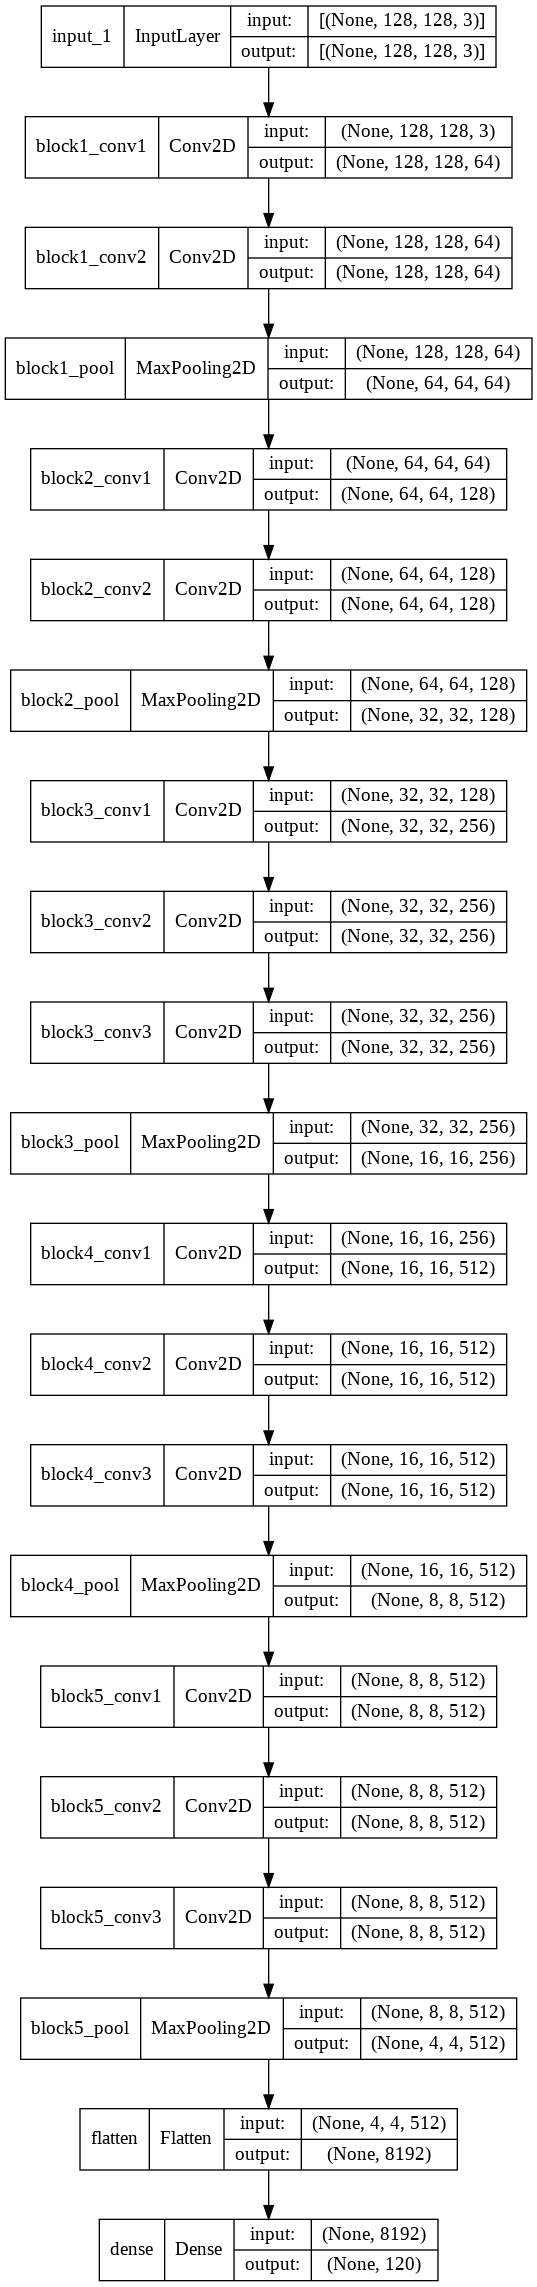

In [ ]:
# Displaying model
plot_model(model_vgg16, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('mnist_cnn_vgg16.h5')

In [ ]:
%%time
# start training
history=model_vgg16.fit(X_train, y_train,
          batch_size=batch_sz,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(X_test, y_test), 
          callbacks=[callback])

In [ ]:
model_vgg16.save('drive/MyDrive/Colab Notebooks/cnn_vgg16')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/cnn_vgg16/assets


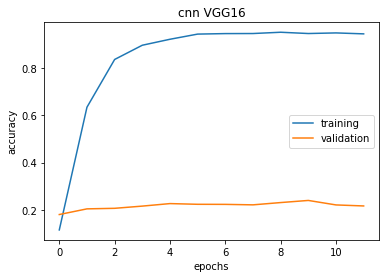

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn VGG16')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [ ]:
# Evaluate and print accuracy
score = model_vgg16.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## VGG19

In [ ]:
model_vgg19 = create_model_vgg19(img_w,img_h)

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

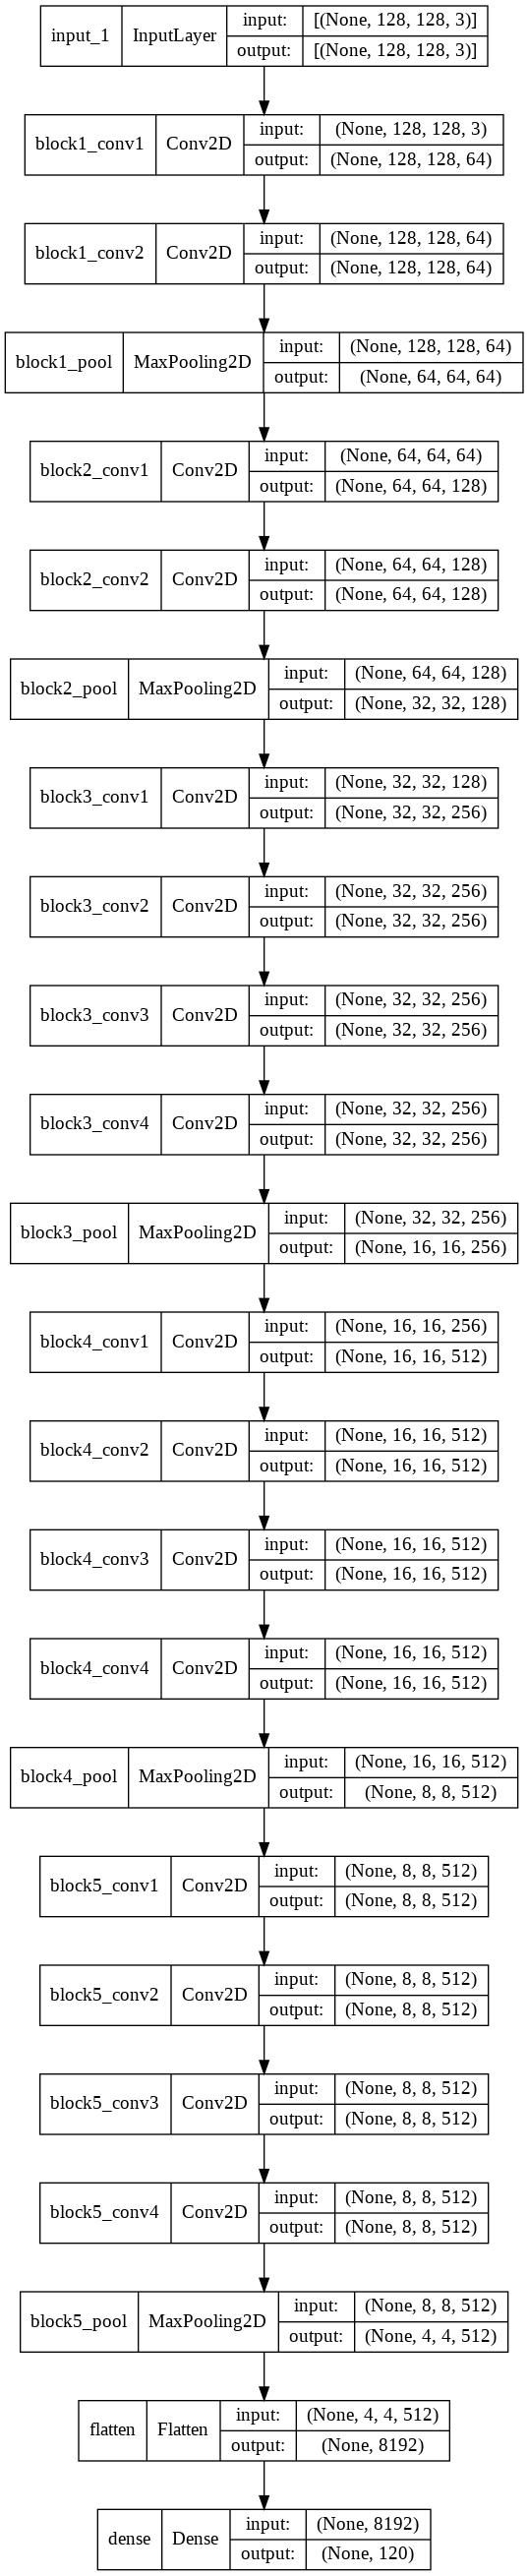

In [ ]:
# Displaying model
plot_model(model_vgg19, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('cnn_vgg19.h5')

In [ ]:
%%time
# start training
history=model_vgg19.fit(X_train, y_train,
          batch_size=batch_sz,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(X_test, y_test), 
          callbacks=[callback])

In [ ]:
model_vgg19.save('drive/MyDrive/Colab Notebooks/cnn_vgg19')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/cnn_vgg19/assets


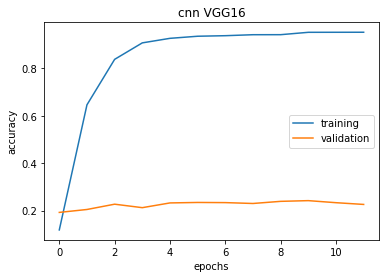

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn VGG19')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [ ]:
# Evaluate and print accuracy
score = model_vgg19.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Layers visualization

### Filters

In [ ]:
for layer in model.layers:    
    if 'conv' in layer.name:            
        filters , bias = layer.get_weights()
        print(layer.name , filters.shape) #filters.shape = A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]

In [ ]:
filters.shape[3]

In [ ]:
# retrieve weights from the hidden layer
filters , bias = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

#n_filters =32
n_filters=filters.shape[3]
j=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for channel in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,j)
        plt.imshow(f[:,:,channel])
        j+=1
#plot the filters 
plt.show()

### Features

In [ ]:
# couches de convolution
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' in layer.name:    
        print(i , layer.name , layer.output.shape)

In [ ]:
img=XSubset[77]
plt.imshow(img)
image=(np.expand_dims(img, axis=0)).astype(float)
image=std_image(image)

In [ ]:
len(model.layers)

In [ ]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)-2]]
# couches d'activation avec entrées et sorties
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs) #puts together the input and output functions of the CNN model

In [ ]:
activation_model.summary()

In [ ]:
#calculating features
activations = activation_model.predict(image)

In [ ]:
for activation_layer in activation_model.layers:
    print(f"Shape of {activation_layer.name} -> {activation_layer.output.shape}")

In [ ]:
len(activations), range(len(activations)-1)

In [ ]:
# Getting Activations of first layer
nth_layer_activation = activations[1]
  
# shape of first layer activation
print(nth_layer_activation.shape, nth_layer_activation.shape[3])
  
# 6th channel of the image after first layer of convolution is applied
plt.matshow(nth_layer_activation[0, :, :, 0], cmap ='viridis')
  
# 15th channel of the image after first layer of convolution is applied
plt.matshow(nth_layer_activation[0, :, :, 2], cmap ='viridis')

In [ ]:
range(1,nth_layer_activation.shape[3]), 32//8, 32%8

In [ ]:
n=2
num_row=8
num_col=8


# Gettubg activation of nth layer
nth_layer_activation = activations[n]
  
# shape of nth layer activation
print(nth_layer_activation.shape, nth_layer_activation.shape[3]-1)

# plot activation layer's channels
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

for c in range(nth_layer_activation.shape[3]):
    ax = axes[c//num_col, c%num_col]
    ax.imshow(nth_layer_activation[0, :, :, c], cmap='viridis')
    ax.set_title(f'Channel-{c}')
plt.show()